In [1]:
import pandas as pd
import json
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')
import numpy as np
from transformers import BertModel, BertTokenizer
import torch
from tqdm import tqdm

#clustering
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics
from sklearn.metrics import calinski_harabasz_score
from functools import reduce

#ext
import math
import yake
from nltk.corpus import stopwords
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import itertools
nltk.download('stopwords')
from numpy import exp
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from deep_translator import GoogleTranslator
from collections import defaultdict
import rouge

#combine
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import operator
from bert_score import score


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Import Data TripAdvisor

Data TripAdvisor yang di-*import* merupakan hasil dari pra-proses dan data disimpan menggunakan pandas pada kode di bawah ini.

In [2]:
ext = pd.read_csv('./sep_raw_review_revisi.csv').reset_index()
ext = ext.drop('Unnamed: 0', axis=1)

In [3]:
ext.head()

,index,review,abstractive,kategori,review_cln
0,0,Nice place klo lagi nyari tempat staycation d...,"Hotel berada di pusat kota, dekat untuk ke sta...",labeled-hotel,nice place kalo lagi mencari tempat staycation...
1,1,Sangat senang bisa kembali lagi ke hotel muli...,Pelayanan sangat baik secara keseluruhan dari ...,labeled-hotel,sangat senang bisa kembali lagi ke hotel mulia...
2,2,"Hotel nya sangat strategis, dekat kebun raya ...",Lokasi strategis karena di di dekat hotel ada ...,labeled-hotel,hotel nya sangat strategis [SEP] dekat kebun r...
3,3,Di kamar 1610 sangat memuaskan. Sangat bersih...,Pelayanan ramah dan memuaskan. Staf benar-bena...,labeled-hotel,di kamar 1610 sangat memuaskan [SEP] hanya saj...
4,4,Menginap untuk 3 malam. Begitu masuk ke kamar...,Hotel memiliki desain yang modern dan minimali...,labeled-hotel,menginap untuk 3 malam [SEP] begitu masuk ke k...


Selanjutnya data disimpan dalam bentuk *dictionary* untuk memudahkan proses selanjutnya.

In [4]:
doc = []
for i in range(len(ext)):
  doc.append({
      'index' : ext['index'],
      'sentence' : ext['review_cln'][i].split('[SEP]')
  })

### Embedding Kalimat Menggunakan Model BERT

Tahapan pertama melakukan inisialisasi tokenisasi dan model yang digunakan untuk BERT. Panjang token sejumlah 512 sesuai dengan panjang maksimal model BERT

In [5]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1', padding="max_length", truncation=True, max_length=512)
model = BertModel.from_pretrained('indobenchmark/indobert-base-p1', output_hidden_states = True)

Pembuatan fungsi untuk menyimpan *hidden layer* sebagai embedding kalimat dari model BERT

In [6]:
# Inisialisasi awal untuk gpu, jumlah hidden layer terakhir untuk digabung menjadi satu vektor, dan pooling strategy
use_gpu = False 
n_combined_hidden_states = 2
pooling_mode = 1 
if use_gpu:
    model.to('cuda')

# Mengambil hidden layer model BERT
def sentence2bert_hidden_states(sentence, tokenizer, model, use_gpu = True):
    indexed_tokens = tokenizer.encode(sentence)
    tokens_tensor = torch.tensor([indexed_tokens])
    if use_gpu:
        tokens_tensor = tokens_tensor.to('cuda')
    with torch.no_grad():
        outputs = model(tokens_tensor)        
    hidden_states = outputs[2]
    hidden_states = torch.stack(hidden_states, dim=0)
    hidden_states = torch.squeeze(hidden_states, dim=1)
    hidden_states = hidden_states.permute(1,0,2)    
    return hidden_states, indexed_tokens

# Menggabungkan hidden layer 
def combine_hidden_states(hidden_states, n_summands):
    n = hidden_states.shape[0]    
    assert n_summands <= hidden_states.shape[1]    
    combined = np.empty((hidden_states.shape[0],hidden_states.shape[2]))
    for i in range(n):
        combined[i,:] = torch.sum(hidden_states[i][-n_summands:], dim=0).cpu()[:]
    return combined

# Melakukan proses embedding token
def sentence2token_embeddings(sentence, tokenizer, model, use_gpu = True, n_combined_hidden_states = 4):
    hidden_states, indexed_tokens = sentence2bert_hidden_states(sentence, tokenizer, model, use_gpu)
    token_embeddings = combine_hidden_states(hidden_states, n_combined_hidden_states)
    return token_embeddings, indexed_tokens

# Melakukan proses embedding kalimat menggunakan mean
def sentence2embedding(sentence, tokenizer, model, use_gpu = True, n_combined_hidden_states = 4, pooling_mode = 0):
    token_embeddings, indexed_tokens = sentence2token_embeddings(sentence, tokenizer, model, use_gpu, n_combined_hidden_states)
    if pooling_mode == 0:
        return token_embeddings[0]
    else:
        return np.mean(token_embeddings, axis = 0)

# Menyimpan kalimat dan hasil embedding kalimatnya
def text2sentence_embeddings(text_sentences, tokenizer, model, use_gpu = True, n_combined_hidden_states = 2, pooling_mode = 0):
    n_text_sentences = len(text_sentences)
    text_embeddings = np.empty((n_text_sentences, model.config.hidden_size))
    for i in range(n_text_sentences):
        text_embeddings[i,:] = sentence2embedding(text_sentences[i], tokenizer, model, use_gpu, n_combined_hidden_states, pooling_mode)[:]
    return text_embeddings

def sentence_embeddings(data):
  text_embeddings = text2sentence_embeddings(data, 
                                                tokenizer, 
                                                model, 
                                                use_gpu, 
                                                n_combined_hidden_states, 
                                                pooling_mode)
  return text_embeddings

### Metode Clustering untuk Penghapusan Topik yang Tidak Penting

Pemilihan metode clustering berdasarkan nilai Silhouette Coefficient (SC), Davies Bouldin Index (DBI), dan Halinksi Harabaz (HB). Berikut fungsi untuk ketiga metode evaluasi unsupervised

In [9]:
def dbi (model_c, embedding, k_max):
  if model_c == 'Agglomerative':
    model = AgglomerativeClustering(k_max).fit(embedding)
  elif model_c =='KMeans':
    model = KMeans(k_max).fit(embedding)
  else:
    model = KMedoids(k_max, init='k-medoids++').fit(embedding)

  dbi = davies_bouldin_score(embedding, model.labels_)

  return dbi

In [11]:
def chi(model, embedding, k_max):
  if model=='Agglomerative':
    model = AgglomerativeClustering(k_max).fit(embedding)
  elif model=='KMeans':
    model = KMeans(n_clusters=k_max).fit(embedding)
  else:
    model = KMedoids(k_max, init='k-medoids++').fit(embedding)

  chi = calinski_harabasz_score(embedding, model.labels_)
  
  return chi

Metode Silhouette juga digunakan untuk menghitung jumlah klaster optimal

In [185]:
def get_silhouette (model_c, embedding, k_max):
  silhouette = {}

  for k in range(2, k_max):
    if model_c =='Agglomerative':
      model = AgglomerativeClustering(n_clusters=k).fit(embedding)
    elif model_c =='KMeans':
      model = KMeans(n_clusters=k).fit(embedding)
    else:
      model = KMedoids(n_clusters=k, init='k-medoids++').fit(embedding)
    silhouette[k] = silhouette_score(embedding, model.labels_)

  max_value = max(silhouette.values())
  max_index = max(silhouette, key=silhouette.get)

  return max_index, max_value

Metode Elbow digunakan untuk menghitung jumlah klaster optimal. Dari metode Silhouette dan Elbow akan digunakan jumlah klaster tertinggi

In [192]:
def elbow(model_c, embedding, k_max):
  if model_c=='Agglomerative':
    elb_visualizer = KElbowVisualizer(AgglomerativeClustering(), k=(2,k_max), timings=False).fit(embedding)
  elif model_c=='KMeans':
    elb_visualizer = KElbowVisualizer(KMeans(), k=(2,k_max), timings=False).fit(embedding)
  else:
    elb_visualizer = KElbowVisualizer(KMedoids(init='k-medoids++'), k=(2,k_max), timings=False).fit(embedding)

  max_index = elb_visualizer.elbow_value_
  max_value = elb_visualizer.elbow_score_
  
  return max_index, max_value

Tahapan awal dilakukan pengurangan dimensi menggunakan PCA karena pada saat menggunakan dimensi asli dari model BERT yaitu 729 menghasilkan jumlah klaster yang lebih banyak. Hal ini akan menyebabkan metode clustering lebih sensitif terhadap pengelompokkan kalimatnya.

Tahapan berikutnya mencari jumlah klaster optimal menggunakan silhouette dan elbow, dimana jumlah klaster tertinggi akan digunakan sebagai inisialisasi jumlah klaster untuk metode clustering.

In [200]:
def n_clustering(model_c, embeddingr, k_max):
    pca = PCA(n_components=2)
    embedding = pca.fit_transform(embeddingr)
    clus = []

    ss, score_s = get_silhouette(model_c, embedding, k_max)
    el, score_e = elbow(model_c, embedding, k_max)

    clus = [ss, el]
            
    print(clus)
    clus.sort(reverse=True)
    clus_opt = {x:clus.count(x) for x in clus}
    index_max = max(clus_opt, key=clus_opt.get)
    print(index_max)
    
    score_chi = chi(model_c, embedding, index_max)
    score_dbi = dbi(model_c, embedding, index_max)
    alscore = [score_s, score_chi, score_dbi]
    
    return index_max, alscore

def clustering(model_c, embedding,n_cluster):
    if model_c =='Agglomerative':
      clus = AgglomerativeClustering(n_clusters=n_cluster).fit_predict(embedding)
    elif model_c =='KMeans':
      clus = KMeans(n_clusters=n_cluster).fit_predict(embedding)
    else:
      clus = KMedoids(n_clusters=n_cluster, init='k-medoids++').fit_predict(embedding)

    return clus

Pencarian jumlah klaster optimal dilakukan dari rentang 2 sampai 10. Penentuan jumlah maksimal berdasarkan penelitian sebelumnya [Cahyaningtyas dkk., 2021](https://doi.org/10.22219/kinetik.v6i3.1300) dimana topik yang muncul dalam ulasan tidak lebih dari 10.

Pada file perbandingan_clustering.ipynb telah dilakukan proses pencarian metode clustering maksimal untuk Data TripAdvisor sehingga pada fungsi di bawah hanya melakukan eksekusi program untuk metode terbaik yaitu K-Means 

In [206]:
def clustering_sent(model_c, data, cls_max=False):
    data_ext = {}

    for d in range(len(data)):
        y = data[d]['sentence']
        embedding = sentence_embeddings(y)
        tmp_txt = []
        tmp_clus = []

        k_max = 10
        
        print('data '+str(d))
        cls, score = n_clustering(model_c, embedding, k_max)
        agg = clustering(model_c, embedding,cls)

        for i in range(len(y)):
            tmp_txt.append(y[i])
            tmp_clus.append(agg[i])
        
        data_ext[d] = {}
        data_ext[d]['text'] = tmp_txt
        data_ext[d]['cluster'] = tmp_clus
        data_ext[d]['score_clus'] = score

    return data_ext

data 0
[4, 4]
4
data 1
[4, 4]
4
data 2
[9, 5]
9
data 3
[5, 5]
5
data 4
[9, 4]
9
data 5
[3, 3]
3
data 6
[3, 4]
4
data 7
[8, 4]
8
data 8
[6, 4]
6
data 9
[2, 4]
4
data 10
[6, 5]
6
data 11
[3, 4]
4
data 12
[8, 4]
8
data 13
[6, 4]
6
data 14
[3, 3]
3
data 15
[4, 4]
4
data 16
[8, 4]
8
data 17
[3, 4]
4
data 18
[3, 4]
4
data 19
[2, 4]
4
data 20
[6, 5]
6
data 21
[4, 4]
4
data 22
[3, 4]
4
data 23
[3, 3]
3
data 24
[4, 4]
4
data 25
[3, 4]
4
data 26
[9, 5]
9
data 27
[6, 5]
6
data 28
[2, 4]
4
data 29
[7, 4]
7
data 30
[3, 4]
4
data 31
[2, 4]
4
data 32
[9, 4]
9
data 33
[9, 4]
9
data 34
[3, 4]
4
data 35
[5, 4]
5
data 36
[3, 3]
3
data 37
[3, 3]
3
data 38
[7, 5]
7
data 39
[2, 4]
4
data 40
[3, 4]
4
data 41
[9, 4]
9
data 42
[9, 3]
9
data 43
[7, 4]
7
data 44
[6, 4]
6
data 45
[3, 4]
4
data 46
[5, 4]
5
data 47
[3, 4]
4
data 48
[3, 4]
4
data 49
[6, 4]
6
data 50
[2, 4]
4
data 51
[3, 4]
4
data 52
[3, 4]
4
data 53
[4, 4]
4
data 54
[7, 4]
7
data 55
[7, 4]
7
data 56
[3, 4]
4
data 57
[3, 4]
4
data 58
[3, 3]
3
data 59

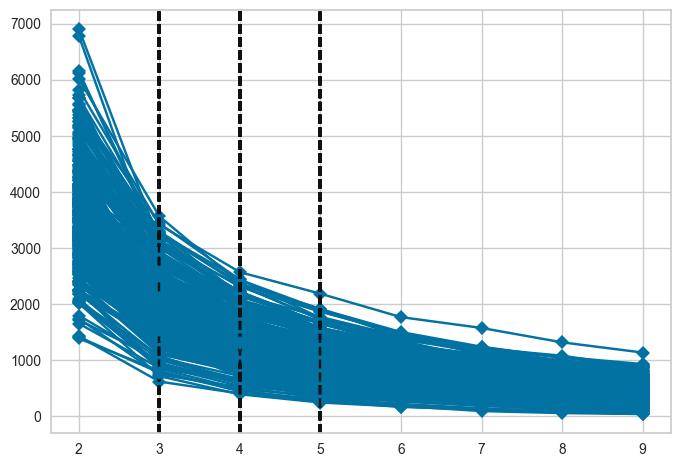

In [252]:
model_c = 'KMeans'
data_ext = clustering_sent(model_c, doc)

Setelah dilakukan proses *clustering*, hasil klaster dapat disimpan pada json dengan kode di bawah ini.

In [347]:
with open("./juti/result_tripadvisor/file-uploads/clustering-kmeans2.json","w") as f:
    json.dump(data_ext,f, default=int)

Meng-*import* hasil *clustering* yang sudah disimpan sebelumnya.

In [35]:
f= open("./clustering-kmeans.json")
data_ext = json.load(f)

### Tahapan Ekstraktif Menggunakan Kombinasi Fitur: Relevansi, Keterbaruan Informasi/*Novelty*, Posisi, dan *Sentiment-keyword* (RKiPS) 

**Fitur Relevansi** didapatkan dari kedekatan kalimat dengan centroid. Fitur ini menunjukkan bahwa nilai yang tinggi memiliki kedekatan informasi dengan topik utama. Kedekatan antara kalimat dengan centroid dilakukan berdasarkan perhitungan cosine similarity.

In [15]:
# Fungsi untuk menghitung cosine similarity
def cosine(u, v):
  return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [16]:
# Fungsi untuk menghitung relevansi dengan menggunakan parameter centroid dan embedding kalimat
def content_relevance(centroid,hypothesis_embeddings):
  d = {}
  for sentence,embed in hypothesis_embeddings.items():
    d[sentence] = cosine(centroid,embed)
    
  return d

**Fitur keterbaruan informasi/*Novelty*** digunakan mendapatkan informasi baru dan mengurangi redundansi dari ringkasan. Fitur ini berdasarkan nilai *threshold* untuk menghitung suatu kalimat apakah memiliki informasi baru atau tidak. Suatu kalimat akan dibandingkan dengan kalimat lain pada dokumen yang sama untuk melihat kedekatan antar kalimatnya. Terdapat 3 kondisi untuk fitur keterbaruan informasi/*novelty* antara lain:
1. Apabila suatu kalimat memiliki kedekatan antar kalimat lainnya yang rendah dibandingkan nilai *threshold* maka kalimat tersebut memiliki nilai *novelty* yang tinggi yaitu 1.
2. Apabila suatu kalimat memiliki kedekatan antar kalimat lainnya yang lebih tinggi dibandingkan nilai *treshold* maka terdapat kondisi berikutnya yang perlu dicek yaitu apabila kalimat memiliki nilai relevansi yang tinggi dibandingkan dengan kalimat lainnya yang ada di dokumen tersebut maka memiliki nilai *novelty* yang tinggi yaitu 1.
3. Apabila tidak memenuhi kondisi diatas maka memiliki nilai -> 1-max_similarity.

In [160]:
# Fungsi untuk menghitung keterbaruan informasi/novelty dengan menggunakan parameter nilai relevansi dan embedding kalimat
def sentence_novelty(content_relevance_score,hypothesis_embeddings):
  novel_sentences = {}
  TAU = 0.95
  for sent1,embed1 in hypothesis_embeddings.items():
    max_similarity = 0
    for sent2,embed2 in hypothesis_embeddings.items():
      if sent1!=sent2 and cosine(embed1,embed2)>max_similarity:
          max_similarity = cosine(embed1,embed2)

    # Kondisi 1
    if max_similarity<TAU:
      novel_sentences[sent1] = 1

    # Kondisi 2
    elif max_similarity>TAU:
      if content_relevance_score[sent1]>content_relevance_score[sent2]:
        novel_sentences[sent1] = 1
      else:
        novel_sentences[sent1] = 1-max_similarity

    # Kondisi 3
    else:
      novel_sentences[sent1] = 1-max_similarity

  return novel_sentences

**Fitur posisi** menerapkan konsep bahwa kalimat pada posisi pertama memiliki nilai yang lebih tinggi dibandingkan kalimat yang jauh dari posisi pertama.

In [18]:
def sentence_position(hypothesis):
  score_sent = {}
  for i,sent in enumerate(hypothesis):
      score_sent[sent] = max(0.5,math.exp(-(i+1)/(len(hypothesis)**(1/3))))
  
  return score_sent

**Fitur *sentiment-keyword*** terdiri dari *sentiment* yang digunakan untuk mendapatkan nilai opini dari sebuah kalimat yang berfungsi untuk menilai sebuah topik bahasan, sedangkan *keyword* untuk mendapatkan nilai penting berupa *n-gram* pada sebuah dokumen.

In [19]:
# Fungsi untuk mengekstraksi keyword menggunakan model YAKE
def keyword_extractor(text):
    kword = []
    kw_extractor = yake.KeywordExtractor()
    keywords = kw_extractor.extract_keywords(text)
    
    for kw in range(len(keywords)):
        kword.append(keywords[kw])
    
    keywords = sorted(kword,key=lambda x:(-x[1],x[0]))

    return keywords

Pada bagian *keyword* diawali dengan penghapusan *stopwords* agar mengurangi *keyword* yang memiliki kata-kata yang tidak penting seperti kata hubung. Kemudian model Yake akan mengekstraksi keyword berdasarkan dokumen. Kalimat-kalimat yang memiliki atau terdiri dari kata *keyword* maka akan dihitung sebagai fitur *keyword*, dimana nilai setiap *keyword* dihasilkan dari model Yake. Nilai-nilai *keyword* yang telah terkumpul akan dijumlahkan sehingga suatu kalimat akan memiliki nilai akhir untuk *keyword*.

In [20]:
# Fungsi untuk menghapus stopwords untuk proses ekstraksi keyword
def remove_stop_words(text):
    stop_factory = stopwords.words('indonesian')
    clean_words = []
    text = word_tokenize(text)
    for word in text:
        if word not in stop_factory:
            clean_words.append(word)
    return " ".join(clean_words)

def stem_process(text):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  return stemmer.stem(text)

def key_clean_process(text, stem=False):
    text = remove_stop_words(text)
    if stem==True:
      text = stem_process(text)
    return text

In [21]:
# Proses ekstraksi keyword dengan fungsi yang telah dibuat sebelumnya
data_k = []
for d in range(len(doc)):
  clean_ = ' '.join(doc[d]['sentence'])
  clean_ = key_clean_process(clean_)
  data_k.append(clean_)

data_key = {}
for i in range(len(data_k)):
  data_key[i] = (keyword_extractor(data_k[i]))

In [230]:
# Contoh hasil keyword dari dokumen dengan indeks i=0
data_key[0]

'kolam renang nya'

In [348]:
# Menyimpan keyword yang telah diekstraksi
with open("./juti/result_tripadvisor/file-uploads/keyword2.json","w") as f:
    json.dump(data_key,f, default=int)

Pada bagian *sentiment* didapatkan nilai dari model VADER yang memiliki leksikon Bahasa Inggris. Oleh karena itu, penerapan VADER pada Bahasa Indonesia diawali dengan menerjemahkan dokumen Bahasa Indonesia ke Bahasa Inggris dengan menggunakan *library* "deep_translator"

In [237]:
# Fungsi untuk mendapatkan nilai sentiment menggunakan model VADER
vader_sentiment = SentimentIntensityAnalyzer()
def vader_sentiment_scores(text):
  score = vader_sentiment.polarity_scores(text)
  return score['compound']

def prediksiSentiment(kalimat):
    # Penerjemah Bahasa Indonesia ke Bahasa Inggris
    translated = GoogleTranslator(source='auto', target='en').translate(kalimat)
    wordlist = len(word_tokenize(kalimat))
    val = abs(vader_sentiment_scores(translated)/wordlist)
    return val

In [238]:
def normalization_sen(text, keyword):
  lprob = []
  for i,sent in enumerate(text):
    val = prediksiSentiment(sent)
    
    nk = []
    for k in range(len(keyword)):
      split_keyword = keyword[k][0].split()
      for sk in split_keyword:
        if sk in sent:
          nk.append(keyword[k][1]) 
    key = np.sum(nk)
        
    prob = key + val
    lprob.append(prob)

  score_sent = {}
  for i,sent in enumerate(text):
    score_sent[sent] = lprob[i]
  
  return score_sent

Penggabungan kombinasi fitur yang telah dijelaskan di atas serta perhitungan nilai akhir dengan perkalian bobot untuk setiap fitur, dimana bobot *alpha* dikalikan dengan fitur relevansi, bobot *beta* dikalikan dengan fitur keterbaruan informasi/*novelty*, bobot *gamma* dikalikan dengan fitur posisi, dan bobot *teta* dikalikan dengan fitur *sentiment-keyword*.

Bagian ini juga merupakan proses lanjutan untuk penhapusan topik yang tidak penting dari hasil *clustering*. Pada variabel after_clus adalah dokumen baru setelah penghapusan topik tidak penting dengan ketentuan jumlah anggota klaster lebih dari 2.

In [253]:
def total_score(alpha, beta, gamma, teta, content_relevance_score, sentence_novelty_score, sentiment, sentence_pos):
  final_score = {}
  for sent in content_relevance_score:
    final_score[sent] = (alpha*content_relevance_score[sent])+(beta*sentence_novelty_score[sent])+(gamma*sentence_pos[sent])+(teta*sentiment[sent])
  final_score = {k: v for k, v in sorted(final_score.items(), key=lambda item: item[1],reverse=True)}
      
  return final_score

def convert_to_embeddings(alpha, beta, gamma, teta, text_sentences, text_embeddings, keyword, sentence_pos):
  hypothesis_embeddings = {}
  sum = 0
  index = 0

  for sent in text_sentences:
    var = text_embeddings[index]
    sum += var
    hypothesis_embeddings[sent] = var
    index += 1

  centroid = sum/len(text_sentences)
  
  content_relevance_score = content_relevance(centroid,hypothesis_embeddings)
  sentence_novelty_score = sentence_novelty(content_relevance_score,hypothesis_embeddings)
  phrasa_score = normalization_sen(text_sentences, keyword)
  return total_score(alpha, beta, gamma, teta, content_relevance_score, sentence_novelty_score, phrasa_score, sentence_pos)

def iter_ext(data, data_pos, alpha, beta, gamma, teta):
    extractive = []
    result_dict = defaultdict(list)

    for index,v in tqdm(data.items()):

        datapoint_length = {x:data[index]['cluster'].count(x) for x in data[index]['cluster']}
        sentence_pos = sentence_position(data_pos[int(index)]['sentence'])
        after_clus = []
        for c in range(len(datapoint_length)):
            txt = []

            for t in range (len(data[index]['text'])):
                if data[index]['cluster'][t] == c:
                    txt.append(data[index]['text'][t])

            if len(txt) > 2:
               after_clus.extend(txt)
               
        text_embeddings = sentence_embeddings(after_clus)
        predicted_summary = convert_to_embeddings(alpha, beta, gamma, teta, after_clus, text_embeddings, data_key[int(index)], sentence_pos) 
        result_dict[index].append(predicted_summary)

    return result_dict

extract_skp = iter_ext(data_ext, doc, 0.5, 0.2, 0.2, 0.1)

100%|██████████| 300/300 [1:25:03<00:00, 17.01s/it]


In [345]:
with open("./juti/result_tripadvisor/file-uploads/skoring-rkips2.json","w") as f:
    json.dump(extract_skp,f, default=int)

In [22]:
import json
f= open(r"../main/extract_skp_2.json")
extract_skp = json.load(f)

In [281]:
def summary2(text):
    extractive = []
    for dc,v in text.items():
        tmp_ext = []
        val_cls = [v for v in text[dc][0].values()]
        key_cls = [k for k in text[dc][0].keys()]
        for vc in range(len(val_cls)):
          if len(word_tokenize(' '.join(tmp_ext))) <= 90:
            tmp_ext.append(key_cls[vc])
            
        extractive.append('\n'.join(tmp_ext))
    return extractive

In [282]:
acsum = []
for smm in range(len(ext['abstractive'])):
  acsum.append(ext['abstractive'][smm].replace('.','.\n'))

In [15]:
evaluator = rouge.Rouge(metrics=['rouge-n', 'rouge-l'],
                           max_n=2,
                           limit_length=True,
                           length_limit=100,
                           length_limit_type='words',
                           apply_avg=True,
                           alpha=0.5, # Default F1_score
                           weight_factor=1.2,
                           stemming=False)
raw_ext1 = summary2(extract_skp)
scores = evaluator.get_scores(raw_ext1, acsum)
scores

NameError: name 'summary2' is not defined

CLUSTERING+3FITUR

In [29]:
def total_score(alpha, beta, gamma, content_relevance_score, sentence_novelty_score, position_score):
  final_score = {}
  for sent in content_relevance_score:
    final_score[sent] = alpha*content_relevance_score[sent]+beta*sentence_novelty_score[sent]+gamma*position_score[sent]
  final_score = {k: v for k, v in sorted(final_score.items(), key=lambda item: item[1],reverse=True)}
      
  return final_score

def convert_to_embeddings(alpha, beta, gamma, text_sentences, text_embeddings):
  hypothesis_embeddings = {}
  sum = 0
  index = 0

  for sent in text_sentences:
    var = text_embeddings[index]
    sum += var
    hypothesis_embeddings[sent] = var
    index += 1

  centroid = sum/len(text_sentences)
  
  content_relevance_score = content_relevance(centroid,hypothesis_embeddings)
  sentence_novelty_score = sentence_novelty(content_relevance_score,hypothesis_embeddings)
  position_score = sentence_position(text_sentences)
  return total_score(alpha, beta, gamma, content_relevance_score, sentence_novelty_score, position_score)

def iter_ext(data):
    extractive = []
    index = 0
    
    result_dict = defaultdict(list)

    for i in tqdm(range(len(data))):
        total = 0
        print('data ke ' + str(i))
        text_embeddings = sentence_embeddings(data[i]['sentence'])
        predicted_summary = convert_to_embeddings(0.6, 0.2, 0.2, data[i]['sentence'], text_embeddings) 
          
        result_dict[i].append(predicted_summary)

    return result_dict

extract_p = iter_ext(doc)

  0%|          | 0/300 [00:00<?, ?it/s]

data ke 0


  0%|          | 1/300 [00:01<06:20,  1.27s/it]

data ke 1


  1%|          | 2/300 [00:02<05:46,  1.16s/it]

data ke 2


  1%|          | 3/300 [00:03<06:50,  1.38s/it]

data ke 3


  1%|▏         | 4/300 [00:05<06:32,  1.33s/it]

data ke 4


  2%|▏         | 5/300 [00:06<06:34,  1.34s/it]

data ke 5


  2%|▏         | 6/300 [00:08<06:52,  1.40s/it]

data ke 6


  2%|▏         | 7/300 [00:09<06:54,  1.42s/it]

data ke 7


  3%|▎         | 8/300 [00:10<06:49,  1.40s/it]

data ke 8


  3%|▎         | 9/300 [00:12<06:33,  1.35s/it]

data ke 9


  3%|▎         | 10/300 [00:13<06:49,  1.41s/it]

data ke 10


  4%|▎         | 11/300 [00:15<07:21,  1.53s/it]

data ke 11


  4%|▍         | 12/300 [00:17<08:12,  1.71s/it]

data ke 12


  4%|▍         | 13/300 [00:18<07:20,  1.54s/it]

data ke 13


  5%|▍         | 14/300 [00:20<07:41,  1.61s/it]

data ke 14


  5%|▌         | 15/300 [00:22<08:08,  1.71s/it]

data ke 15


  5%|▌         | 16/300 [00:23<07:22,  1.56s/it]

data ke 16


  6%|▌         | 17/300 [00:25<07:22,  1.57s/it]

data ke 17


  6%|▌         | 18/300 [00:26<07:26,  1.58s/it]

data ke 18


  6%|▋         | 19/300 [00:28<07:43,  1.65s/it]

data ke 19


  7%|▋         | 20/300 [00:30<07:24,  1.59s/it]

data ke 20


  7%|▋         | 21/300 [00:31<07:08,  1.54s/it]

data ke 21


  7%|▋         | 22/300 [00:32<06:10,  1.33s/it]

data ke 22


  8%|▊         | 23/300 [00:33<05:49,  1.26s/it]

data ke 23


  8%|▊         | 24/300 [00:35<06:20,  1.38s/it]

data ke 24


  8%|▊         | 25/300 [00:36<06:13,  1.36s/it]

data ke 25


  9%|▊         | 26/300 [00:38<06:23,  1.40s/it]

data ke 26


  9%|▉         | 27/300 [00:39<06:12,  1.36s/it]

data ke 27


  9%|▉         | 28/300 [00:41<06:41,  1.48s/it]

data ke 28


 10%|▉         | 29/300 [00:42<07:05,  1.57s/it]

data ke 29


 10%|█         | 30/300 [00:44<07:03,  1.57s/it]

data ke 30


 10%|█         | 31/300 [00:45<06:57,  1.55s/it]

data ke 31


 11%|█         | 32/300 [00:47<07:04,  1.58s/it]

data ke 32


 11%|█         | 33/300 [00:49<07:11,  1.62s/it]

data ke 33


 11%|█▏        | 34/300 [00:50<07:09,  1.62s/it]

data ke 34


 12%|█▏        | 35/300 [00:52<07:24,  1.68s/it]

data ke 35


 12%|█▏        | 36/300 [00:54<07:10,  1.63s/it]

data ke 36


 12%|█▏        | 37/300 [00:55<07:19,  1.67s/it]

data ke 37


 13%|█▎        | 38/300 [00:57<07:09,  1.64s/it]

data ke 38


 13%|█▎        | 39/300 [00:59<07:27,  1.72s/it]

data ke 39


 13%|█▎        | 40/300 [01:00<06:55,  1.60s/it]

data ke 40


 14%|█▎        | 41/300 [01:02<07:20,  1.70s/it]

data ke 41


 14%|█▍        | 42/300 [01:04<07:32,  1.75s/it]

data ke 42


 14%|█▍        | 43/300 [01:06<07:22,  1.72s/it]

data ke 43


 15%|█▍        | 44/300 [01:07<06:54,  1.62s/it]

data ke 44


 15%|█▌        | 45/300 [01:08<06:27,  1.52s/it]

data ke 45


 15%|█▌        | 46/300 [01:10<06:33,  1.55s/it]

data ke 46


 16%|█▌        | 47/300 [01:11<06:21,  1.51s/it]

data ke 47


 16%|█▌        | 48/300 [01:13<06:17,  1.50s/it]

data ke 48


 16%|█▋        | 49/300 [01:14<05:46,  1.38s/it]

data ke 49


 17%|█▋        | 50/300 [01:15<05:35,  1.34s/it]

data ke 50


 17%|█▋        | 51/300 [01:17<05:39,  1.36s/it]

data ke 51


 17%|█▋        | 52/300 [01:18<05:45,  1.39s/it]

data ke 52


 18%|█▊        | 53/300 [01:19<05:31,  1.34s/it]

data ke 53


 18%|█▊        | 54/300 [01:21<05:28,  1.34s/it]

data ke 54


 18%|█▊        | 55/300 [01:22<05:54,  1.45s/it]

data ke 55


 19%|█▊        | 56/300 [01:24<05:55,  1.46s/it]

data ke 56


 19%|█▉        | 57/300 [01:25<06:04,  1.50s/it]

data ke 57


 19%|█▉        | 58/300 [01:27<06:14,  1.55s/it]

data ke 58


 20%|█▉        | 59/300 [01:29<06:04,  1.51s/it]

data ke 59


 20%|██        | 60/300 [01:30<06:00,  1.50s/it]

data ke 60


 20%|██        | 61/300 [01:32<06:31,  1.64s/it]

data ke 61


 21%|██        | 62/300 [01:34<06:48,  1.72s/it]

data ke 62


 21%|██        | 63/300 [01:36<06:57,  1.76s/it]

data ke 63


 21%|██▏       | 64/300 [01:38<07:16,  1.85s/it]

data ke 64


 22%|██▏       | 65/300 [01:39<06:33,  1.68s/it]

data ke 65


 22%|██▏       | 66/300 [01:41<06:34,  1.68s/it]

data ke 66


 22%|██▏       | 67/300 [01:42<06:20,  1.63s/it]

data ke 67


 23%|██▎       | 68/300 [01:44<06:12,  1.61s/it]

data ke 68


 23%|██▎       | 69/300 [01:45<05:36,  1.46s/it]

data ke 69


 23%|██▎       | 70/300 [01:46<05:25,  1.42s/it]

data ke 70


 24%|██▎       | 71/300 [01:48<05:37,  1.47s/it]

data ke 71


 24%|██▍       | 72/300 [01:49<05:28,  1.44s/it]

data ke 72


 24%|██▍       | 73/300 [01:51<05:40,  1.50s/it]

data ke 73


 25%|██▍       | 74/300 [01:52<05:46,  1.54s/it]

data ke 74


 25%|██▌       | 75/300 [01:54<05:31,  1.47s/it]

data ke 75


 25%|██▌       | 76/300 [01:55<05:36,  1.50s/it]

data ke 76


 26%|██▌       | 77/300 [01:56<04:53,  1.32s/it]

data ke 77


 26%|██▌       | 78/300 [01:57<04:41,  1.27s/it]

data ke 78


 26%|██▋       | 79/300 [01:58<04:11,  1.14s/it]

data ke 79


 27%|██▋       | 80/300 [02:00<04:42,  1.29s/it]

data ke 80


 27%|██▋       | 81/300 [02:01<04:36,  1.26s/it]

data ke 81


 27%|██▋       | 82/300 [02:03<05:04,  1.40s/it]

data ke 82


 28%|██▊       | 83/300 [02:04<04:52,  1.35s/it]

data ke 83


 28%|██▊       | 84/300 [02:06<05:02,  1.40s/it]

data ke 84


 28%|██▊       | 85/300 [02:07<05:09,  1.44s/it]

data ke 85


 29%|██▊       | 86/300 [02:09<05:38,  1.58s/it]

data ke 86


 29%|██▉       | 87/300 [02:10<05:04,  1.43s/it]

data ke 87


 29%|██▉       | 88/300 [02:12<05:32,  1.57s/it]

data ke 88


 30%|██▉       | 89/300 [02:13<05:06,  1.45s/it]

data ke 89


 30%|███       | 90/300 [02:15<05:06,  1.46s/it]

data ke 90


 30%|███       | 91/300 [02:16<05:14,  1.50s/it]

data ke 91


 31%|███       | 92/300 [02:18<05:42,  1.64s/it]

data ke 92


 31%|███       | 93/300 [02:20<05:27,  1.58s/it]

data ke 93


 31%|███▏      | 94/300 [02:21<04:59,  1.45s/it]

data ke 94


 32%|███▏      | 95/300 [02:22<04:55,  1.44s/it]

data ke 95


 32%|███▏      | 96/300 [02:24<05:09,  1.52s/it]

data ke 96


 32%|███▏      | 97/300 [02:25<05:07,  1.51s/it]

data ke 97


 33%|███▎      | 98/300 [02:27<05:01,  1.49s/it]

data ke 98


 33%|███▎      | 99/300 [02:29<05:16,  1.57s/it]

data ke 99


 33%|███▎      | 100/300 [02:30<04:56,  1.48s/it]

data ke 100


 34%|███▎      | 101/300 [02:31<04:37,  1.40s/it]

data ke 101


 34%|███▍      | 102/300 [02:33<05:00,  1.52s/it]

data ke 102


 34%|███▍      | 103/300 [02:34<04:44,  1.45s/it]

data ke 103


 35%|███▍      | 104/300 [02:35<04:14,  1.30s/it]

data ke 104


 35%|███▌      | 105/300 [02:36<03:58,  1.22s/it]

data ke 105


 35%|███▌      | 106/300 [02:37<03:59,  1.24s/it]

data ke 106


 36%|███▌      | 107/300 [02:39<04:18,  1.34s/it]

data ke 107


 36%|███▌      | 108/300 [02:40<04:16,  1.34s/it]

data ke 108


 36%|███▋      | 109/300 [02:42<04:37,  1.45s/it]

data ke 109


 37%|███▋      | 110/300 [02:44<05:05,  1.61s/it]

data ke 110


 37%|███▋      | 111/300 [02:45<04:35,  1.46s/it]

data ke 111


 37%|███▋      | 112/300 [02:47<04:39,  1.49s/it]

data ke 112


 38%|███▊      | 113/300 [02:48<04:07,  1.32s/it]

data ke 113


 38%|███▊      | 114/300 [02:49<04:00,  1.29s/it]

data ke 114


 38%|███▊      | 115/300 [02:50<04:17,  1.39s/it]

data ke 115


 39%|███▊      | 116/300 [02:53<04:54,  1.60s/it]

data ke 116


 39%|███▉      | 117/300 [02:54<04:49,  1.58s/it]

data ke 117


 39%|███▉      | 118/300 [02:56<04:53,  1.61s/it]

data ke 118


 40%|███▉      | 119/300 [02:57<04:20,  1.44s/it]

data ke 119


 40%|████      | 120/300 [02:58<04:06,  1.37s/it]

data ke 120


 40%|████      | 121/300 [03:00<04:20,  1.46s/it]

data ke 121


 41%|████      | 122/300 [03:01<04:01,  1.36s/it]

data ke 122


 41%|████      | 123/300 [03:02<03:41,  1.25s/it]

data ke 123


 41%|████▏     | 124/300 [03:04<04:10,  1.42s/it]

data ke 124


 42%|████▏     | 125/300 [03:05<04:11,  1.44s/it]

data ke 125


 42%|████▏     | 126/300 [03:07<04:15,  1.47s/it]

data ke 126


 42%|████▏     | 127/300 [03:08<04:00,  1.39s/it]

data ke 127


 43%|████▎     | 128/300 [03:08<03:17,  1.15s/it]

data ke 128


 43%|████▎     | 129/300 [03:10<03:29,  1.22s/it]

data ke 129


 43%|████▎     | 130/300 [03:12<03:52,  1.37s/it]

data ke 130


 44%|████▎     | 131/300 [03:13<03:55,  1.40s/it]

data ke 131


 44%|████▍     | 132/300 [03:15<04:09,  1.48s/it]

data ke 132


 44%|████▍     | 133/300 [03:16<04:01,  1.44s/it]

data ke 133


 45%|████▍     | 134/300 [03:18<04:06,  1.49s/it]

data ke 134


 45%|████▌     | 135/300 [03:18<03:22,  1.23s/it]

data ke 135


 45%|████▌     | 136/300 [03:19<03:13,  1.18s/it]

data ke 136


 46%|████▌     | 137/300 [03:22<04:00,  1.48s/it]

data ke 137


 46%|████▌     | 138/300 [03:23<04:05,  1.51s/it]

data ke 138


 46%|████▋     | 139/300 [03:24<03:43,  1.39s/it]

data ke 139


 47%|████▋     | 140/300 [03:26<04:04,  1.53s/it]

data ke 140


 47%|████▋     | 141/300 [03:28<04:19,  1.63s/it]

data ke 141


 47%|████▋     | 142/300 [03:29<04:07,  1.57s/it]

data ke 142


 48%|████▊     | 143/300 [03:31<04:05,  1.56s/it]

data ke 143


 48%|████▊     | 144/300 [03:32<03:54,  1.50s/it]

data ke 144


 48%|████▊     | 145/300 [03:34<03:55,  1.52s/it]

data ke 145


 49%|████▊     | 146/300 [03:35<03:36,  1.41s/it]

data ke 146


 49%|████▉     | 147/300 [03:37<03:49,  1.50s/it]

data ke 147


 49%|████▉     | 148/300 [03:38<03:43,  1.47s/it]

data ke 148


 50%|████▉     | 149/300 [03:40<04:05,  1.63s/it]

data ke 149


 50%|█████     | 150/300 [03:41<03:41,  1.48s/it]

data ke 150


 50%|█████     | 151/300 [03:43<03:51,  1.56s/it]

data ke 151


 51%|█████     | 152/300 [03:44<03:34,  1.45s/it]

data ke 152


 51%|█████     | 153/300 [03:45<03:27,  1.41s/it]

data ke 153


 51%|█████▏    | 154/300 [03:47<03:15,  1.34s/it]

data ke 154


 52%|█████▏    | 155/300 [03:48<03:19,  1.37s/it]

data ke 155


 52%|█████▏    | 156/300 [03:50<03:40,  1.53s/it]

data ke 156


 52%|█████▏    | 157/300 [03:52<03:45,  1.58s/it]

data ke 157


 53%|█████▎    | 158/300 [03:53<03:22,  1.42s/it]

data ke 158


 53%|█████▎    | 159/300 [03:54<03:15,  1.39s/it]

data ke 159


 53%|█████▎    | 160/300 [03:56<03:34,  1.53s/it]

data ke 160


 54%|█████▎    | 161/300 [03:57<03:35,  1.55s/it]

data ke 161


 54%|█████▍    | 162/300 [03:59<03:24,  1.48s/it]

data ke 162


 54%|█████▍    | 163/300 [04:01<03:42,  1.62s/it]

data ke 163


 55%|█████▍    | 164/300 [04:03<04:00,  1.77s/it]

data ke 164


 55%|█████▌    | 165/300 [04:05<04:05,  1.82s/it]

data ke 165


 55%|█████▌    | 166/300 [04:07<03:59,  1.79s/it]

data ke 166


 56%|█████▌    | 167/300 [04:08<03:29,  1.58s/it]

data ke 167


 56%|█████▌    | 168/300 [04:08<02:52,  1.30s/it]

data ke 168


 56%|█████▋    | 169/300 [04:10<02:55,  1.34s/it]

data ke 169


 57%|█████▋    | 170/300 [04:11<02:47,  1.29s/it]

data ke 170


 57%|█████▋    | 171/300 [04:13<03:10,  1.47s/it]

data ke 171


 57%|█████▋    | 172/300 [04:15<03:26,  1.61s/it]

data ke 172


 58%|█████▊    | 173/300 [04:16<03:21,  1.59s/it]

data ke 173


 58%|█████▊    | 174/300 [04:18<03:12,  1.53s/it]

data ke 174


 58%|█████▊    | 175/300 [04:19<02:50,  1.37s/it]

data ke 175


 59%|█████▊    | 176/300 [04:20<02:55,  1.41s/it]

data ke 176


 59%|█████▉    | 177/300 [04:22<03:04,  1.50s/it]

data ke 177


 59%|█████▉    | 178/300 [04:24<03:24,  1.68s/it]

data ke 178


 60%|█████▉    | 179/300 [04:25<03:06,  1.54s/it]

data ke 179


 60%|██████    | 180/300 [04:26<02:49,  1.42s/it]

data ke 180


 60%|██████    | 181/300 [04:28<02:57,  1.49s/it]

data ke 181


 61%|██████    | 182/300 [04:29<02:28,  1.26s/it]

data ke 182


 61%|██████    | 183/300 [04:30<02:30,  1.28s/it]

data ke 183


 61%|██████▏   | 184/300 [04:31<02:34,  1.33s/it]

data ke 184


 62%|██████▏   | 185/300 [04:33<02:36,  1.36s/it]

data ke 185


 62%|██████▏   | 186/300 [04:34<02:15,  1.19s/it]

data ke 186


 62%|██████▏   | 187/300 [04:34<01:56,  1.03s/it]

data ke 187


 63%|██████▎   | 188/300 [04:35<01:56,  1.04s/it]

data ke 188


 63%|██████▎   | 189/300 [04:37<02:06,  1.14s/it]

data ke 189


 63%|██████▎   | 190/300 [04:38<01:58,  1.08s/it]

data ke 190


 64%|██████▎   | 191/300 [04:38<01:47,  1.01it/s]

data ke 191


 64%|██████▍   | 192/300 [04:40<01:50,  1.03s/it]

data ke 192


 64%|██████▍   | 193/300 [04:41<02:10,  1.22s/it]

data ke 193


 65%|██████▍   | 194/300 [04:42<01:54,  1.08s/it]

data ke 194


 65%|██████▌   | 195/300 [04:43<01:47,  1.02s/it]

data ke 195


 65%|██████▌   | 196/300 [04:44<01:49,  1.05s/it]

data ke 196


 66%|██████▌   | 197/300 [04:45<01:31,  1.12it/s]

data ke 197


 66%|██████▌   | 198/300 [04:46<01:41,  1.01it/s]

data ke 198


 66%|██████▋   | 199/300 [04:47<01:59,  1.18s/it]

data ke 199


 67%|██████▋   | 200/300 [04:48<01:54,  1.15s/it]

data ke 200


 67%|██████▋   | 201/300 [04:50<01:54,  1.16s/it]

data ke 201


 67%|██████▋   | 202/300 [04:51<01:53,  1.16s/it]

data ke 202


 68%|██████▊   | 203/300 [04:52<02:02,  1.27s/it]

data ke 203


 68%|██████▊   | 204/300 [04:54<01:58,  1.23s/it]

data ke 204


 68%|██████▊   | 205/300 [04:55<02:09,  1.37s/it]

data ke 205


 69%|██████▊   | 206/300 [04:56<02:04,  1.32s/it]

data ke 206


 69%|██████▉   | 207/300 [04:58<01:57,  1.27s/it]

data ke 207


 69%|██████▉   | 208/300 [04:59<01:57,  1.28s/it]

data ke 208


 70%|██████▉   | 209/300 [05:00<02:01,  1.33s/it]

data ke 209


 70%|███████   | 210/300 [05:02<02:02,  1.36s/it]

data ke 210


 70%|███████   | 211/300 [05:03<02:11,  1.47s/it]

data ke 211


 71%|███████   | 212/300 [05:05<02:05,  1.42s/it]

data ke 212


 71%|███████   | 213/300 [05:06<02:03,  1.42s/it]

data ke 213


 71%|███████▏  | 214/300 [05:07<01:58,  1.38s/it]

data ke 214


 72%|███████▏  | 215/300 [05:09<02:09,  1.52s/it]

data ke 215


 72%|███████▏  | 216/300 [05:11<02:04,  1.48s/it]

data ke 216


 72%|███████▏  | 217/300 [05:12<02:08,  1.55s/it]

data ke 217


 73%|███████▎  | 218/300 [05:14<02:03,  1.50s/it]

data ke 218


 73%|███████▎  | 219/300 [05:15<02:02,  1.51s/it]

data ke 219


 73%|███████▎  | 220/300 [05:17<01:59,  1.49s/it]

data ke 220


 74%|███████▎  | 221/300 [05:18<02:02,  1.55s/it]

data ke 221


 74%|███████▍  | 222/300 [05:20<01:59,  1.54s/it]

data ke 222


 74%|███████▍  | 223/300 [05:22<02:00,  1.57s/it]

data ke 223


 75%|███████▍  | 224/300 [05:23<02:01,  1.59s/it]

data ke 224


 75%|███████▌  | 225/300 [05:25<01:52,  1.49s/it]

data ke 225


 75%|███████▌  | 226/300 [05:26<01:50,  1.50s/it]

data ke 226


 76%|███████▌  | 227/300 [05:27<01:35,  1.31s/it]

data ke 227


 76%|███████▌  | 228/300 [05:28<01:32,  1.28s/it]

data ke 228


 76%|███████▋  | 229/300 [05:29<01:22,  1.16s/it]

data ke 229


 77%|███████▋  | 230/300 [05:30<01:14,  1.06s/it]

data ke 230


 77%|███████▋  | 231/300 [05:31<01:12,  1.06s/it]

data ke 231


 77%|███████▋  | 232/300 [05:32<01:11,  1.05s/it]

data ke 232


 78%|███████▊  | 233/300 [05:33<01:10,  1.06s/it]

data ke 233


 78%|███████▊  | 234/300 [05:35<01:18,  1.19s/it]

data ke 234


 78%|███████▊  | 235/300 [05:36<01:15,  1.16s/it]

data ke 235


 79%|███████▊  | 236/300 [05:37<01:13,  1.15s/it]

data ke 236


 79%|███████▉  | 237/300 [05:37<01:01,  1.03it/s]

data ke 237


 79%|███████▉  | 238/300 [05:38<00:57,  1.08it/s]

data ke 238


 80%|███████▉  | 239/300 [05:40<01:09,  1.14s/it]

data ke 239


 80%|████████  | 240/300 [05:41<01:11,  1.19s/it]

data ke 240


 80%|████████  | 241/300 [05:42<01:06,  1.13s/it]

data ke 241


 81%|████████  | 242/300 [05:44<01:11,  1.24s/it]

data ke 242


 81%|████████  | 243/300 [05:44<01:05,  1.14s/it]

data ke 243


 81%|████████▏ | 244/300 [05:46<01:13,  1.31s/it]

data ke 244


 82%|████████▏ | 245/300 [05:47<01:12,  1.31s/it]

data ke 245


 82%|████████▏ | 246/300 [05:49<01:07,  1.25s/it]

data ke 246


 82%|████████▏ | 247/300 [05:50<01:10,  1.33s/it]

data ke 247


 83%|████████▎ | 248/300 [05:51<00:58,  1.12s/it]

data ke 248


 83%|████████▎ | 249/300 [05:52<00:57,  1.13s/it]

data ke 249


 83%|████████▎ | 250/300 [05:53<00:53,  1.07s/it]

data ke 250


 84%|████████▎ | 251/300 [05:54<00:57,  1.18s/it]

data ke 251


 84%|████████▍ | 252/300 [05:56<00:58,  1.23s/it]

data ke 252


 84%|████████▍ | 253/300 [05:58<01:08,  1.45s/it]

data ke 253


 85%|████████▍ | 254/300 [05:58<00:57,  1.24s/it]

data ke 254


 85%|████████▌ | 255/300 [05:59<00:55,  1.23s/it]

data ke 255


 85%|████████▌ | 256/300 [06:01<00:52,  1.20s/it]

data ke 256


 86%|████████▌ | 257/300 [06:02<00:58,  1.37s/it]

data ke 257


 86%|████████▌ | 258/300 [06:04<00:54,  1.31s/it]

data ke 258


 86%|████████▋ | 259/300 [06:05<00:53,  1.29s/it]

data ke 259


 87%|████████▋ | 260/300 [06:06<00:55,  1.39s/it]

data ke 260


 87%|████████▋ | 261/300 [06:07<00:48,  1.25s/it]

data ke 261


 87%|████████▋ | 262/300 [06:08<00:38,  1.02s/it]

data ke 262


 88%|████████▊ | 263/300 [06:09<00:36,  1.02it/s]

data ke 263


 88%|████████▊ | 264/300 [06:10<00:43,  1.21s/it]

data ke 264


 88%|████████▊ | 265/300 [06:12<00:43,  1.25s/it]

data ke 265


 89%|████████▊ | 266/300 [06:13<00:39,  1.16s/it]

data ke 266


 89%|████████▉ | 267/300 [06:15<00:50,  1.54s/it]

data ke 267


 89%|████████▉ | 268/300 [06:17<00:48,  1.51s/it]

data ke 268


 90%|████████▉ | 269/300 [06:17<00:37,  1.22s/it]

data ke 269


 90%|█████████ | 270/300 [06:19<00:37,  1.26s/it]

data ke 270


 90%|█████████ | 271/300 [06:20<00:38,  1.33s/it]

data ke 271


 91%|█████████ | 272/300 [06:21<00:33,  1.21s/it]

data ke 272


 91%|█████████ | 273/300 [06:22<00:34,  1.29s/it]

data ke 273


 91%|█████████▏| 274/300 [06:24<00:32,  1.23s/it]

data ke 274


 92%|█████████▏| 275/300 [06:25<00:29,  1.19s/it]

data ke 275


 92%|█████████▏| 276/300 [06:26<00:29,  1.22s/it]

data ke 276


 92%|█████████▏| 277/300 [06:27<00:28,  1.23s/it]

data ke 277


 93%|█████████▎| 278/300 [06:28<00:23,  1.08s/it]

data ke 278


 93%|█████████▎| 279/300 [06:30<00:27,  1.30s/it]

data ke 279


 93%|█████████▎| 280/300 [06:31<00:26,  1.32s/it]

data ke 280


 94%|█████████▎| 281/300 [06:33<00:25,  1.35s/it]

data ke 281


 94%|█████████▍| 282/300 [06:33<00:21,  1.19s/it]

data ke 282


 94%|█████████▍| 283/300 [06:35<00:24,  1.44s/it]

data ke 283


 95%|█████████▍| 284/300 [06:37<00:24,  1.51s/it]

data ke 284


 95%|█████████▌| 285/300 [06:38<00:22,  1.47s/it]

data ke 285


 95%|█████████▌| 286/300 [06:40<00:20,  1.49s/it]

data ke 286


 96%|█████████▌| 287/300 [06:41<00:19,  1.48s/it]

data ke 287


 96%|█████████▌| 288/300 [06:43<00:18,  1.52s/it]

data ke 288


 96%|█████████▋| 289/300 [06:44<00:16,  1.46s/it]

data ke 289


 97%|█████████▋| 290/300 [06:46<00:14,  1.41s/it]

data ke 290


 97%|█████████▋| 291/300 [06:47<00:12,  1.43s/it]

data ke 291


 97%|█████████▋| 292/300 [06:48<00:10,  1.37s/it]

data ke 292


 98%|█████████▊| 293/300 [06:50<00:09,  1.37s/it]

data ke 293


 98%|█████████▊| 294/300 [06:51<00:07,  1.27s/it]

data ke 294


 98%|█████████▊| 295/300 [06:52<00:06,  1.30s/it]

data ke 295


 99%|█████████▊| 296/300 [06:53<00:04,  1.06s/it]

data ke 296


 99%|█████████▉| 297/300 [06:54<00:03,  1.25s/it]

data ke 297


 99%|█████████▉| 298/300 [06:56<00:02,  1.29s/it]

data ke 298


100%|█████████▉| 299/300 [06:57<00:01,  1.18s/it]

data ke 299


100%|██████████| 300/300 [06:58<00:00,  1.39s/it]


In [344]:
with open("./juti/result_tripadvisor/file-uploads/skoring-rkip2.json","w") as f:
    json.dump(extract_p,f, default=int)

In [28]:
import json
f= open(r"../main/extract_p.json")
extract_p = json.load(f)

In [284]:
raw_ext2 = summary2(extract_p)
scores = evaluator.get_scores(raw_ext2, acsum)
scores

{'rouge-2': {'f': 0.06770161077120225,
  'p': 0.05175546864675708,
  'r': 0.10377812749120068},
 'rouge-1': {'f': 0.2793907696331645,
  'p': 0.21292131573920287,
  'r': 0.43152485399361995},
 'rouge-l': {'f': 0.3289068045183421,
  'p': 0.25930698497805327,
  'r': 0.46889303378649744}}

In [285]:
raw_ext1[4].split('\n')

[' menu dinner boxnya pun sangat enak untuk sarapan masih diantar ke kamar dengan 6 menu pilihan yang diberikan front office ',
 'menginap untuk 3 malam ',
 ' saya dan pasangan puas dengan fasilitas kamar mandi beserta toilet nya ',
 ' untuk menu sarapan yang diantar ke kamar ',
 ' dengan desain yang modern dan minimalis kamar yang saya tempati terbilang luas dengan harga yang kompetitif untuk hotel smart budget ',
 ' cita rasa makanan di restonya juga lumayan enak dengan harga yang terjangkau ',
 ' jika mencari wisata kuliner hotel ini kurang cocok karena makanan kaki lima warung juga sangat sulit ditemukan mini market hanya ada 1 seminggu yang lalu kami check ini dan kami memberikan masukan memgenai kebersihan kamar ']

In [286]:
raw_ext2[4].split('\n')

[' menu dinner boxnya pun sangat enak untuk sarapan masih diantar ke kamar dengan 6 menu pilihan yang diberikan front office ',
 'menginap untuk 3 malam ',
 ' saya dan pasangan puas dengan fasilitas kamar mandi beserta toilet nya ',
 ' untuk menu sarapan yang diantar ke kamar ',
 ' dengan desain yang modern dan minimalis kamar yang saya tempati terbilang luas dengan harga yang kompetitif untuk hotel smart budget ',
 ' cita rasa makanan di restonya juga lumayan enak dengan harga yang terjangkau ',
 ' jika mencari wisata kuliner hotel ini kurang cocok karena makanan kaki lima warung juga sangat sulit ditemukan mini market hanya ada 1 seminggu yang lalu kami check ini dan kami memberikan masukan memgenai kebersihan kamar ']

In [287]:
from bert_score import score

eP, eR, eF1 = score(raw_ext1, acsum, model_type="indobert-base-p1", num_layers=12)
eF1.mean()

tensor(0.5177)

In [288]:
eP, eR, eF1 = score(raw_ext2, acsum, model_type="indobert-base-p1", num_layers=12)
eF1.mean()

tensor(0.5170)

### Perbandingan dengan Metode Unsupervised Lainnya Pada Penelitian Sebelumnya

Model RKiPS dibandingkan dengan metode unsupervised lainnya yaitu Textrank, Textteaser, dan BERT Ekstraktif. Berikut penjelasan singkat 3 metode tersebut.
1. Textrank merupakan metode berbasis graf berbasis algoritma PageRank, dimana setiap kalimat direpresentasikan sebagai simpul (node) dan hubungan antar kalimat direpresentasikan sebagai tepi (edge). Setiap simpul kalimat akan diberikan bobot berdasarkan tingkatan kepentingan kalimat. Metode ini digunakan pada penelitian sebelumnya oleh [Gunawan dkk., 2019](https://doi.org/10.1109/ICISS48059.2019.8969785)
2. Textteaser merupakan kombinasi fitur secara sintatik menggunakan metode Textteaser yang terdiri dari fitur judul, fitur posisi, dan fitur keyword. Metode ini digunakan paada penelitian sebelumnya oleh [Gunawan dkk., 2017](https://doi.org/10.1088/1757-899X/190/1/012048)
3. BERT Ekstraktif merupakan model BERT yang digunakan untuk melakukan peringkasan teks dengan memilih kalimat-kalimat penting berdasarkan model yang sudah dilatih sebelumnya. Metode ini diusulkan oleh [Liu dkk., 2019](https://arxiv.org/abs/1903.10318)

**TEXTRANK**

In [12]:
from summa.summarizer import summarize

prepro_textrank = []
for i in range(len(doc)):
    prepro_textrank.append('\n'.join(doc[i]['sentence']))

textrank_sum = []
for tsum in range(len(doc)):
    textrank_sum.append(summarize(prepro_textrank[tsum], words=90))

scorestk = evaluator.get_scores(textrank_sum, acsum)

In [15]:
# BERTScore
_, _, tkF1 = score(textrank_sum, acsum, model_type="indobert-base-p1", num_layers=12)
tkF1.mean()

tensor(0.4891)

**TextTeaser**

In [9]:
import sys
sys.path.append('./textteasersum/textteaser/')

In [10]:
from textteasersum.textteaser import TextTeaser

def sumtextteaser(y,x):
  tt = TextTeaser()

  sentences = tt.summarize(y, x)
  return sentences

prepro_tt = []
for i in range(len(doc)):
    prepro_tt.append('. '.join(doc[i]['sentence']))


title = []
for tl in range(len(doc)):
    title.append(doc[tl]['sentence'][0])

textteaser_sum = []
for tl in range(len(doc)):
    textteaser_sum.append(sumtextteaser(title[tl], prepro_tt[tl]))

In [11]:
textteaser_sum = ['\n'.join(x) for x in textteaser_sum]
scorestt = evaluator.get_scores(textteaser_sum, acsum)

In [16]:
# BERTScore
_, _, ttF1 = score(textteaser_sum, acsum, model_type="indobert-base-p1", num_layers=12)
ttF1.mean()

tensor(0.4977)

**BERT Ekstraktif**

In [22]:
acsum = []
for smm in range(len(ext['abstractive'])):
  acsum.append(ext['abstractive'][smm].replace('.','.\n'))

def prepare_results(m, f):
    return '\t{}:\t{}: {:5.2f}'.format(m, 'F1', 100.0 * f)

def bert_result(bertscore):
  return '\t{}: {:5.2f}'.format('BertScore', 100.0 * bertscore)

evaluator = rouge.Rouge(metrics=['rouge-n', 'rouge-l'],
                           max_n=2,
                           limit_length=True,
                           length_limit=100,
                           length_limit_type='words',
                           apply_avg=True,
                           alpha=0.5, # Default F1_score
                           weight_factor=1.2,
                           stemming=False)

In [6]:
from summarizer import Summarizer
from transformers import AutoConfig, AutoTokenizer, AutoModel

In [7]:
custom_config = AutoConfig.from_pretrained('indobert-base-p1')
custom_config.output_hidden_states=True
custom_tokenizer = AutoTokenizer.from_pretrained('indobert-base-p1')
custom_model = AutoModel.from_pretrained('indobert-base-p1', config=custom_config)

In [8]:
model = Summarizer(custom_model=custom_model, custom_tokenizer=custom_tokenizer)
prepro_bert = []
for i in range(len(doc)):
    prepro_bert.append('. '.join(doc[i]['sentence']))

bert_sum = []
for tsum in range(len(doc)):
    bert_sum.append(model(prepro_bert[tsum]))

scoresbs = evaluator.get_scores(bert_sum, acsum)

In [14]:
# BERTScore
_, _, bertF1 = score(bert_sum, acsum, model_type="indobert-base-p1", num_layers=12)
bertF1.mean()

tensor(0.5172)

In [23]:
print('TEXTRANK')
for metric, results in sorted(scorestk.items(), key=lambda x: x[0]):
        print(prepare_results(metric, results['f']))
print(bert_result(tkF1.mean()))

print('TEXTTEASER')
for metric, results in sorted(scorestt.items(), key=lambda x: x[0]):
        print(prepare_results(metric, results['f']))
print(bert_result(ttF1.mean()))

print('BERTEXTRACTIVE')
for metric, results in sorted(scoresbs.items(), key=lambda x: x[0]):
        print(prepare_results(metric, results['f']))
print(bert_result(bertF1.mean()))

TEXTRANK
	rouge-1:	F1: 26.12
	rouge-2:	F1:  6.27
	rouge-l:	F1: 30.23
	BertScore: 48.91
TEXTTEASER
	rouge-1:	F1: 23.13
	rouge-2:	F1:  5.31
	rouge-l:	F1: 27.48
	BertScore: 49.77
BERTEXTRACTIVE
	rouge-1:	F1: 25.79
	rouge-2:	F1:  5.90
	rouge-l:	F1: 27.17
	BertScore: 51.72
